In [1]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random
import transformers

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

###Mount and modify file paths:

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
cd drive/MyDrive/cs182-final-proj/data

/content/drive/.shortcut-targets-by-id/1_BDxhxpVNa_RJlekShA9lHHKeK6gSa_y/cs182-final-proj/data


###Train-validation datasets

3682
1700


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

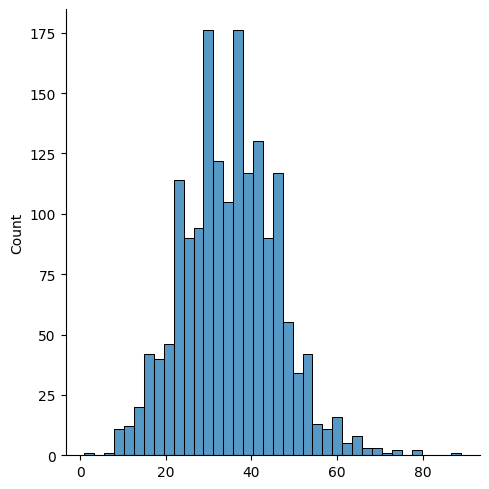

In [14]:
# Choose between RIGHT / LEFT / NEUTRAL
MODEL_TYPE = 'NEUTRAL'

df = pd.read_csv("combined_data.csv")
used_data = []
if MODEL_TYPE == 'RIGHT':
    used_data = df[(df['type'] == 'right') & (df['label_bias'] == 'Biased')]['text']
elif MODEL_TYPE == 'LEFT':
    used_data = df[(df['type'] == 'left') & (df['label_bias'] == 'Biased')]['text']
elif MODEL_TYPE == 'NEUTRAL':
    used_data = df[df['label_bias'] != 'Biased']['text']

print(len(df))
print(len(used_data))

article_lengths = []

for article in used_data:
    # get rough token count distribution
    tokens = nltk.word_tokenize(article)
    article_lengths.append(len(tokens))

article_lengths = np.array(article_lengths)
sns.displot(article_lengths)
np.average(article_lengths)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

class GPT2Dataset(Dataset):
  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]


dataset = GPT2Dataset(used_data, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 5
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)
validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

In [15]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c9600047-3743-3a90-15c8-2d83183a3557)


# Setup and train LoRA model

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)


model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer)) # otherwise the tokenizer and model tensors won't match up

# Use device CUDA for Google Colab)
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Freezing the original weights


In [17]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

### Setting up the LoRa Adapters and hyper-params

In [18]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [19]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16, #attention heads
    lora_alpha=32, #alpha scaling
    # target_modules=["q_proj", "v_proj"], #if you know the
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM" # set this for CLM or Seq2Seq
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 589824 || all params: 125031168 || trainable%: 0.47174157406895534


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/model.py:336: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [23]:
epochs = 20
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 100

optimizer = AdamW(
  model.parameters(),
  lr = learning_rate,
  eps = epsilon
)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps = warmup_steps,
  num_training_steps = total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:423: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


###Training loops

In [24]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        model.zero_grad()
        outputs = model(
            b_input_ids,
            labels=b_labels,
            attention_mask = b_masks,
            token_type_ids=None
        )
        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,} of {:>5,}. Loss: {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))
            model.eval()
            sample_outputs = model.generate(
                bos_token_id=random.randint(1,30000),
                do_sample=True,
                top_k=50,
                max_length = 200,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():
            outputs  = model(
                b_input_ids,
                attention_mask = b_masks,
                labels=b_labels
            )
            loss = outputs[0]
        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Training Time': training_time,
        'Validation Time': validation_time
    })

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...



======== Epoch 1 / 20 ========
Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.43160372972488403. Elapsed: 0:02:04.
0:  bipartisan"> <a href="https://www.tr">The United States</a> <a href="" href =" http =" http " ;" :" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;;" ;" ;" ;" ;" ;" ;"; " " ;" ; ""> <font style=":bold;:: bold;"><:spacebar height ==3.:spacebar:spacebar:space:spacebar>" ;" ;" ;" ;" ;" ;" ;":spacebar height ==:" } " ;" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;" ;":center:center height=:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.2842150926589966. Elapsed: 0:04:11.
0:  increasing and growing increasing increasing growing increasing increasing continuing to increasing expanding growing increasing increasing expanding increasing increasing increasing continuing to growing increasing continuing to growing growing increasing continuing to growing increasing increasing continuing to growing increasing continuing to growing increasing growing increasing increasing increasing growing increasing growing continuing increasing increasing continuing to growing increasing increasing increasing increasing increasing growing increasing increasing increasing growing increasing increasing continuing to growing increasing growing continuing to growing increasing increasing growing increasing growing growing increasing increasing continuing increasing increasing increasing increasing increasing increasing continuing to growing growing increasing continuing to growing increasing growing growing growi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.18540607392787933. Elapsed: 0:06:18.
0: day to a trip to the American Holocaust Memorial Museum, he said that it was time for an annual commemoration of the Holocaust.
, who said on Tuesday morning to speak on Thursday that they were a day to a visit to the Holocaust museum in Britain.
, who said on Tuesday morning to speak on Thursday that they were a day to a visit to the museum in Britain.

  Average training loss: 1.72
  Training epoch took: 0:06:26

Running Validation...
  Validation Loss: 0.22
  Validation took: 0:00:13

======== Epoch 2 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.2007249891757965. Elapsed: 0:02:04.
0:  Hang was.

Advertisement
 is now a widely traded symbol.
 is currently trading at a trading price of.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.15625043213367462. Elapsed: 0:04:08.
0:  foods. was an online website that made donations and financial pledges to support the homeless and its supporters.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.20185022056102753. Elapsed: 0:06:11.
0:  trail the new Trump administration in its attempt to revive stalled efforts in the region and bring stability to the region.
 Trump administration has faced setbacks in the region and in particular in the last week, having suffered major setbacks, including the deportation of hundreds of migrants, over the weekend, as the Obama administration attempted to address climate change as it tried to build a new power grid and ensure it could provide electricity to nearly million Americans.
 ‏ ‏ ‏ � Donald J. Trump has been a fierce critic of immigrants and immigrants' rights in the U

In February, ‏ � � Trump criticized the Obama administration for allowing a wave of immigrants to enter the country legally, ‏ ‏ ‏ ‏ ‏ ‏ � � ‏ ‏ ‏ ‏ ‏ ‏ � � � ‏ � ‏ ‏ ‏ ‏ � ‏ ‏ ‏ �

  Average training loss: 0.22
  Training epoch took: 0:06:21

Running Validation...
  Validation Loss: 0.19
  Validation took: 0:00:13

======== Epoch 3 / 20 ====

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.24206508696079254. Elapsed: 0:02:04.
0: intend, a statewide coalition of state officials has pledged to provide $ worth of cash for the state's medical marijuana program and improve access to it, in addition to providing for medical marijuana clinics.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.19405266642570496. Elapsed: 0:04:08.
0:  surround. In order to prevent a significant increase in casualties, police and firefighters are deploying pepper spray, tear gas and other devices to deter protesters at demonstrations which have continued.

The U.S. military is conducting airstrikes in Iraq, deploying ground troops, and conducting airstrikes to counter the threat of Islamic State fighters in Iraq and Syria, the White House said Wednesday.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.22497262060642242. Elapsed: 0:06:12.
0:  reflex
 in the case of Terence, whose name has been re-named and is currently undergoing treatment in New Zealand,

  Average training loss: 0.20
  Training epoch took: 0:06:19

Running Validation...
  Validation Loss: 0.18
  Validation took: 0:00:13

======== Epoch 4 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.142343208193779. Elapsed: 0:02:04.
0:  display.
Advertisement



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.1760389357805252. Elapsed: 0:04:07.
0:  pastor
, but as he continued with his remarks, Rev. Timothy McGovern and one of his co-counselor, Kevin O'Connor, accused Mr. Obama of being a bigot — and called for the White House to be defunded and the Justice Department to act.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.17325347661972046. Elapsed: 0:06:11.
0:  illicit and widespread abuse of marijuana has been known to be epidemic in Washington, and officials have pledged to bring marijuana reform into federal and state governments, as well as to prevent marijuana being sold.

  Average training loss: 0.19
  Training epoch took: 0:06:19

Running Validation...
  Validation Loss: 0.18
  Validation took: 0:00:13

======== Epoch 5 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.17988801002502441. Elapsed: 0:02:04.
0:  Liberation (RAN) has issued a report accusing the US of using taxpayer dollars to build factories in a bid to undermine its democratic rule and undermine the United States' ability to stand up to foreign powers.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.14912058413028717. Elapsed: 0:04:06.
0:  Nam (Reuters) - Iran's nuclear watchdog on Tuesday said it was seeking a new five-year extension of its nuclear deal with Britain and other world powers as it faces a daunting challenge from Iran following its nuclear breakout that alarmed both sides.
's chief diplomat Ali Khademi said Tehran was seeking to expand the nuclear deal to provide incentives for the US to develop nuclear weapons.
, also known as KNF, could boost Tehran's capacity to manufacture nuclear warheads by, creating a headache for both countries.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.21093857288360596. Elapsed: 0:06:10.
0: IONKINSON (D),Trump, a former presidential candidate who declared he was running for president in November, said Thursday that he would be attending the inauguration and calling for a permanent ban on the travel of Muslim immigrants.

  Average training loss: 0.19
  Training epoch took: 0:06:18

Running Validation...
  Validation Loss: 0.18
  Validation took: 0:00:13

======== Epoch 6 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.17658165097236633. Elapsed: 0:02:03.
0:  glimpseThe incident came after some of the poorest black people in the US were being blamed for the violence and racial prejudice in the wake of the September 2012 protests that began the nation's deadliest mass shooting in history.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.16829408705234528. Elapsed: 0:04:06.
0:  Laure1,500,000 in donations.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.18842996656894684. Elapsed: 0:06:09.
0: ismThis season, the Dodgers faced the Dodgers, who are facing their biggest competition since the 2010 World Series, in their most important game yet.

  Average training loss: 0.19
  Training epoch took: 0:06:17

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 7 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.17863264679908752. Elapsed: 0:02:03.
0: ounMerry's remarks have drawn anger from many, including Democratic Party Presidential candidate Martin O'Malley, who said the president should consider ending the debate if he lacks the votes to win the White House.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.172787144780159. Elapsed: 0:04:06.
0:  election, Donald Trump endorsed the Iraq War, declaring his candidacy with a message of hope and the promise of "totally free" nations.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.14324507117271423. Elapsed: 0:06:09.
0:  crazyWe will keep fighting until all our health care patients have access to affordable health care — no matter how much they fear losing their jobs.

  Average training loss: 0.18
  Training epoch took: 0:06:16

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 8 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.16806884109973907. Elapsed: 0:02:03.
0:  bench.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.19243603944778442. Elapsed: 0:04:06.
0:  incorporated the term of a person who has had multiple birth defects, or whom the courts have designated as a presumptive cause of death, is the length of time that the person has been disabled, or the extent to which the person has resided for at least 90 days or more from the date of the death to the date of a mental impairment that creates substantial risk to the health of the person.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.186841681599617. Elapsed: 0:06:09.
0: PeterJurors at the U.K. trial of a British man sentenced to 17 years in prison for selling marijuana to customers in Mexico and Canada on Monday rejected a plea deal in the United States that sought reduced sentences and plea deals.

  Average training loss: 0.18
  Training epoch took: 0:06:17

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 9 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.17775724828243256. Elapsed: 0:02:03.
0: uringIt is the result of a massive investigation and massive media coverage from across the world which resulted in the arrest of hundreds of people who have been unlawfully detained for their views on religious liberty, freedom of religion and other issues.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.1312149614095688. Elapsed: 0:04:06.
0:  reproductiveA few days earlier the Republican Senator voted to strip an extension of the President's amnesty for the 9,800 people on the Immigration Watch list pending court appeal.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.18507568538188934. Elapsed: 0:06:09.
0:  zoneIn a shocking development, the police on Monday morning issued a death certificate for an unidentified suspect that has prompted criticism from local residents.

  Average training loss: 0.18
  Training epoch took: 0:06:16

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 10 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.20290392637252808. Elapsed: 0:02:03.
0:  commitsU.S. Sen. Elizabeth Warren (D- Massachusetts) was joined by former Democratic and Republican members of the Democratic Party on Wednesday for a trip to Chicago to make a pitch for the 2016 presidential candidate to avoid pandering to her own party and to avoid pandering to the establishment.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.19091591238975525. Elapsed: 0:04:06.
0:  ironyThe Trump administration was forced to cancel a scheduled visit to the White House this week because it was embroiled in civil lawsuits over a policy that banned the issuance of visas to certain U.S. citizens unless their papers met a rigorous quality of education or have completed school.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.1592775285243988. Elapsed: 0:06:09.
0:  SahHassan Abu Walid has vowed to continue fighting against the Islamic State (IS) and its al Qaeda wing as they continue to slaughter civilians in the western city of Homs, as they are fighting the rebels.

  Average training loss: 0.18
  Training epoch took: 0:06:17

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 11 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.177723228931427. Elapsed: 0:02:03.
0:  BryanThe Daily Caller reported on Sunday that the Obama administration, on the“side” of civil rights, has also taken steps to enforce prosecution of the Ku Klux Klan.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.18280352652072906. Elapsed: 0:04:06.
0:  spiritsIt will be a matter of weeks until the final decision is made in Colorado over the treatment of the animals — but it appears the decision will already be in the hands of a doctor.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.22226862609386444. Elapsed: 0:06:08.
0:  sees, no group has greater impact on American youth than the Muslim majority, according to an analysis published Monday in the Journal of Public Health.

  Average training loss: 0.21
  Training epoch took: 0:06:16

Running Validation...
  Validation Loss: 0.18
  Validation took: 0:00:13

======== Epoch 12 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.17550808191299438. Elapsed: 0:02:03.
0:  hungry for months, they were on the verge of taking steps to defund an illegal abortion center.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.18684881925582886. Elapsed: 0:04:06.
0:  PTThis means that when the time comes to play, it will be too much to ask for this kind of support and support from the community.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.15716908872127533. Elapsed: 0:06:09.
0: üOn April 4, Trump’s speech on climate change and inclusivity was cut short by the removal of “a prominent leader of the radical right’ from a podium by Republican National Committee head Reince Priebus, who tweeted about the candidate”s comments, and as of  Friday evening,” had issued a statement explaining it’s removal.

  Average training loss: 0.18
  Training epoch took: 0:06:17

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 13 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.18230809271335602. Elapsed: 0:02:03.
0: ruceA Republican-controlled federal court overturned a decision by a Texas prosecutor on Monday that barred the prosecution of a former aide on grounds that she sexually abused multiple women during her tenure as an aide to President Donald Trump during her tenure as a U.S. attorney in the Southern District of New York.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.13802582025527954. Elapsed: 0:04:06.
0:  derivatives) in the wake of the financial crisis have been in the minority.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.16552013158798218. Elapsed: 0:06:09.
0:  is about to start a nationwide crusade to stop marijuana use by young people on campuses, where studies show the teen drug can be lethal without the presence of a physician.

  Average training loss: 0.18
  Training epoch took: 0:06:17

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 14 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.18529359996318817. Elapsed: 0:02:03.
0:  remembering-and-dinner and other business-related topics are among the new categories that could raise concerns among health experts.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.17731286585330963. Elapsed: 0:04:06.
0:  SourcesA spokesman for the Centers for Disease Control and Prevention said the report on the virus was not comprehensive and urged Americans not to vaccinate their children.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.14254522323608398. Elapsed: 0:06:09.
0: ems to stop violent crime at the borders and for the United States to prevent all other violent crime from becoming a national security priority.
 national policy as discussed by President Donald Trump on Thursday to implement policies in the areas of gun control and immigration.

  Average training loss: 0.18
  Training epoch took: 0:06:17

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 15 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.19768625497817993. Elapsed: 0:02:03.
0: tzA former student, who was a co-founder of Black Lives Matter, and was arrested in the beating of a white police officer was troubled by video that showed ​a group of officers beating black members of the public. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.145811066031456. Elapsed: 0:04:07.
0: matic on Wednesday to call attention to the violence in Charlottesville, Virginia, by white supremacist and Ku Klux Klan member Richard Spencer, who has been accused of wearing a hat and carrying a bomb, was suspended after being found guilty of inciting violence.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.1567901223897934. Elapsed: 0:06:10.
0:  synd
 of the US Senate is not just about Donald Trump but his campaign. In the coming days, Republicans are expanding their appeal to the wealthy from their base.

  Average training loss: 0.18
  Training epoch took: 0:06:17

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 16 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.18771350383758545. Elapsed: 0:02:03.
0:  gamIn addition to providing affordable healthcare to those in need, ACA enrollees have access to lower rates of prescription drugs and are afforded access to private insurance policies, which are less costly for the government and do not pay for themselves as health care costs.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.19505064189434052. Elapsed: 0:04:07.
0:  injuryA new study from the US Centers for Disease Control and Prevention (CDC) shows that smoking was the dominant cause of preventable heart disease among teens in the US last year.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.1970643550157547. Elapsed: 0:06:10.
0: azaIt is a common view that the death of Michael Floyd’s grandson is part of the cultural shift towards modern-day drugs. This was the case during the second quarter of 2016 when Michael Floyd was killed by a police officer in San Francisco.

  Average training loss: 0.18
  Training epoch took: 0:06:17

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 17 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.16633738577365875. Elapsed: 0:02:03.
0:  membrane.  They are increasingly resistant to heat,  and   must be maintained by extreme heat of any kind  to the point that they cannot move much faster,  or  be left with the risk of their being shot.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.16576535999774933. Elapsed: 0:04:07.
0: ijing' 'radicalisation' 'gears hope of a surge' - analysts
 as much as six times as many Muslims, according to a statistic that would have found large numbers of them in Muslim countries, and that even the most heavily policed would be unable to prevent violent extremism from spreading.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.1517421305179596. Elapsed: 0:06:10.
0:  cast and other groups, including those supporting the Women's March on Washington, have been fighting in court for the right to organize events outside of the capital.

  Average training loss: 0.18
  Training epoch took: 0:06:18

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 18 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.1825525164604187. Elapsed: 0:02:03.
0:  purch to a $12 billion package of payments in an investment fund and to an education fund from the federal government would include the purchase of new U.S. warfighters with the assistance of private private investment fund and a $10 billion offer to the World War II veteran from a wealthy private equity firm, a former aide to Trump said on Tuesday.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.1530887335538864. Elapsed: 0:04:07.
0:  shoulders with a white-haired man wielding a gun on a sidewalk outside.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.18541154265403748. Elapsed: 0:06:10.
0:  builtThe White House said Wednesday that some of the White House officials who had called on Trump to recertify the U.S. nuclear weapons pact reached Monday are being replaced with new White House officials who have pledged to work toward reconciliation.

  Average training loss: 0.18
  Training epoch took: 0:06:17

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 19 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.16438722610473633. Elapsed: 0:02:03.
0:  openly and the media as a whole are increasingly using social media in an attempt to make more informed decision-making decisions regarding treatment.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.2229008823633194. Elapsed: 0:04:06.
0:  haltedThe FBI and DOJ will be launching an investigation into whether Russia colluded with Trump’s campaign or whether some foreign government sponsored or sanctioned the activities that Trump is accused of illegally interfering with.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.15266485512256622. Elapsed: 0:06:10.
0:  NikI don't blame the government for causing the problem...

  Average training loss: 0.18
  Training epoch took: 0:06:17

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

======== Epoch 20 / 20 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   100 of   306. Loss: 0.20744864642620087. Elapsed: 0:02:03.
0:  tinThis was the first major gun control initiative in the United States after Barack Obama’s first administration introduced it in 2010.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   200 of   306. Loss: 0.16158409416675568. Elapsed: 0:04:06.
0:  clinicalThe US government has been trying to implement changes to Medicaid—also known as insurance coverage’s replacement—by the end of fiscal 2016, but that has been hindered by the law’s provision that states must provide coverage to people with preexisting conditions if the Medicaid program is to continue functioning.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch   300 of   306. Loss: 0.181356281042099. Elapsed: 0:06:10.
0: lectionsI don't see why Congress is acting as if the only way they can pass legislation is to filibuster the legislation.

  Average training loss: 0.18
  Training epoch took: 0:06:17

Running Validation...
  Validation Loss: 0.17
  Validation took: 0:00:13

Training complete!
Total training took 2:10:21 (h:mm:ss)


###Figures and model specs

In [25]:
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.720575,0.221837,0:06:26,0:00:13
2,0.218273,0.193488,0:06:21,0:00:13
3,0.201374,0.183203,0:06:19,0:00:13
4,0.194104,0.179561,0:06:19,0:00:13
5,0.189878,0.176758,0:06:18,0:00:13
6,0.187009,0.174555,0:06:17,0:00:13
7,0.184960,0.173703,0:06:16,0:00:13
8,0.183490,0.172801,0:06:17,0:00:13
9,0.182291,0.171699,0:06:16,0:00:13


from matplotlib import pyplot as plt
_df_0['epoch'].plot(kind='hist', bins=20, title='epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Training Loss'].plot(kind='hist', bins=20, title='Training Loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Valid. Loss'].plot(kind='hist', bins=20, title='Valid. Loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Training Time').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='epoch', y='Training Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Training Loss', y='Valid. Loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['Training Loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('epoch', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Training Time')):
  _plot_series(series, series_name, i)
  fig.legend(title='Training Time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('Training Loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['Valid. Loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('epoch', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Training Time')):
  _plot_series(series, series_name, i)
  fig.legend(title='Training Time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('Valid. Loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['epoch']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'epoch'}, axis=1)
              .sort_values('epoch', ascending=True))
  xs = counted['epoch']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('epoch', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Training Time')):
  _plot_series(series, series_name, i)
  fig.legend(title='Training Time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Training Time']
  ys = series['Training Loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Training Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Training Time')):
  _plot_series(series, series_name, i)
  fig.legend(title='Training Time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Training Time')
_ = plt.ylabel('Training Loss')

from matplotlib import pyplot as plt
_df_10['epoch'].plot(kind='line', figsize=(8, 4), title='epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Training Loss'].plot(kind='line', figsize=(8, 4), title='Training Loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Valid. Loss'].plot(kind='line', figsize=(8, 4), title='Valid. Loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Training Time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='epoch', y='Training Time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Training Time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='Training Loss', y='Training Time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Training Time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='Valid. Loss', y='Training Time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

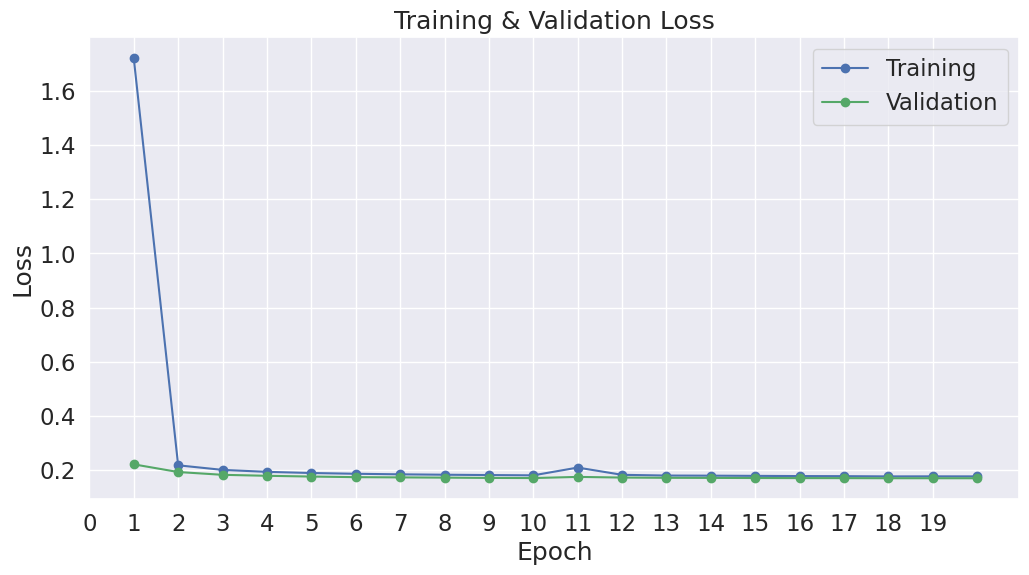

In [26]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i for i in range(epochs)])

plt.show()

In [27]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 172 different named parameters.

==== Embedding Layer ====

base_model.model.transformer.wte.weight                 (50259, 768)
base_model.model.transformer.wpe.weight                  (1024, 768)

==== First Transformer ====

base_model.model.transformer.h.0.ln_1.weight                  (768,)
base_model.model.transformer.h.0.ln_1.bias                    (768,)
base_model.model.transformer.h.0.attn.c_attn.base_layer.weight  (768, 2304)
base_model.model.transformer.h.0.attn.c_attn.base_layer.bias      (2304,)
base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight    (16, 768)
base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight   (2304, 16)
base_model.model.transformer.h.0.attn.c_proj.weight       (768, 768)
base_model.model.transformer.h.0.attn.c_proj.bias             (768,)
base_model.model.transformer.h.0.ln_2.weight                  (768,)
base_model.model.transformer.h.0.ln_2.bias                    (768,)
base_model.model.transformer

In [28]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save3/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save3/


('./model_save3/tokenizer_config.json',
 './model_save3/special_tokens_map.json',
 './model_save3/vocab.json',
 './model_save3/merges.txt',
 './model_save3/added_tokens.json')

###Use the model to generate sample texts

In [40]:
model.eval()

prompt = "Different social occassions"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
    input_ids=generated,  # Assuming 'generated' is your starting input tensor
    do_sample=True,
    top_k=50,
    max_length=200,
    top_p=0.95,
    num_return_sequences=1
)
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[40341,  1919,  1609,   562,   507]], device='cuda:0')
0: Different social occassions between young male-to-female transsexuals and their natural female partners can make their trans and intersex status increasingly uncertain. A survey of more than 2,000 men from both sexes has revealed that more than half (49%) of men who become trans and intersex want to have their partners identify as their gender.


